## Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif



## Visualization Setup

Sets consistent styling for all visualizations and defines helper functions for creating and saving figures with consistent parameters

In [4]:
# Set the style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Define a function to set up figure sizes
def setup_figure(figsize=(10, 6)):
    """Set up a figure with the specified size"""
    return plt.figure(figsize=figsize)

# Define a function to save figures
def save_figure(filename, dpi=300, bbox_inches='tight'):
    """Save the current figure"""
    plt.savefig(filename, dpi=dpi, bbox_inches=bbox_inches)
    

## Data Loading

This function handles loading the Iris dataset from a CSV file with with error handling. The function returns the loaded dataframe or `None` if loading fails, which allows downstream functions to handle missing data.

In [ ]:
# Load Iris Dataset
def load_data(file_path="Data set/iris.csv"):
    """Load the Iris dataset and perform initial checks"""
    try:
        # Try to load the data
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset with shape: {df.shape}")
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None


## Data Exploration

The exploration function performs a thorough examination of the dataset, covering: Basic information (data types, dataframe info), Descriptive, statistics, Missing value detection, Duplicate row detection, Target variable distribution (with visualization), Feature distributions (histograms), Box, plots for features grouped by species, Pairplots to show relationships between, features, Correlation heatmap

In [ ]:
# Data exploration function
def explore_data(df):
    """Perform comprehensive data exploration on the dataset"""
    if df is None:
        return
    
    print("\n=== Data Types ===")
    print(df.dtypes)
    
    print("\n=== DataFrame Information ===")
    print(df.info())
    
    print("\n=== Descriptive Statistics ===")
    print(df.describe())
    
    print("\n=== Missing Values ===")
    missing = df.isnull().sum()
    print(missing)
    
    # Check for duplicate rows
    print("\n=== Duplicate Rows ===")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    
    # Check target variable distribution
    if 'species' in df.columns:
        print("\n=== Target Variable Distribution ===")
        species_counts = df['species'].value_counts()
        print(species_counts)
        
        # Plot target distribution
        setup_figure(figsize=(10, 6))
        ax = species_counts.plot(kind='bar', color=['skyblue', 'coral', 'lightgreen'])
        plt.title('Distribution of Iris Species', fontsize=14)
        plt.xlabel('Species', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.xticks(rotation=0)
        
        # Add count labels on top of bars
        for i, v in enumerate(species_counts):
            ax.text(i, v + 0.5, str(v), ha='center', fontsize=10)
            
        save_figure("species_distribution.png")
        plt.show()
    
    # Visualize feature distributions
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        # Histograms for numeric features
        setup_figure(figsize=(14, 10))
        df[numeric_columns].hist(figsize=(14, 10), bins=20, edgecolor='black')
        plt.suptitle('Feature Distributions', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        save_figure("feature_distributions.png")
        plt.show()
        
        # Box plots for numeric features by species
        if 'species' in df.columns:
            setup_figure(figsize=(14, 10))
            for i, column in enumerate(numeric_columns):
                plt.subplot(2, 2, i+1)
                sns.boxplot(x='species', y=column, data=df)
                plt.title(f'Box Plot of {column} by Species')
            plt.tight_layout()
            save_figure("boxplots_by_species.png")
            plt.show()
            
            # Pairplot to visualize relationships between features
            sns.pairplot(df, hue='species', diag_kind='kde', height=2.5, corner=True)
            plt.suptitle('Pairwise Relationships Between Features', y=1.02, fontsize=16)
            save_figure("feature_pairplot.png")
            plt.show()
            
            # Correlation heatmap
            setup_figure(figsize=(10, 8))
            correlation = df[numeric_columns].corr()
            mask = np.triu(correlation)
            sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
            plt.title('Feature Correlation Heatmap', fontsize=14)
            save_figure("correlation_heatmap.png")
            plt.show()


## Data Preprocessing
The preprocessing function handles several crucial data preparation steps:
1. Creates a copy of the dataframe to avoid modifying the original data
2. Handles missing values (fills numeric columns with median, categorical with mode)
3. Removes duplicate rows
4. Encodes categorical variables using LabelEncoder and preserves the mapping
5. Splits features and target variable
6. Creates train/test splits with stratification to maintain class distribution 

In [ ]:
# Data Preprocessing and Cleaning

def preprocess_data(df):
    """Preprocess and clean the data for modeling"""
    if df is None:
        return None, None, None, None, None
    
    print("\n=== Data Preprocessing ===")
    
    # Make a copy of the dataframe to avoid modifying the original
    df_processed = df.copy()
    
    # Check for missing values and handle them
    if df_processed.isnull().sum().sum() > 0:
        print("Handling missing values...")
        # For numeric columns, fill with median
        numeric_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
        for col in numeric_cols:
            if df_processed[col].isnull().sum() > 0:
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
        
        # For categorical columns, fill with mode
        cat_cols = df_processed.select_dtypes(include=['object']).columns
        for col in cat_cols:
            if df_processed[col].isnull().sum() > 0:
                df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    # Handle duplicates
    if df_processed.duplicated().sum() > 0:
        print("Removing duplicate rows...")
        df_processed = df_processed.drop_duplicates()
    
    # Encode categorical variables if needed
    label_encoders = {}
    if 'species' in df_processed.columns and df_processed['species'].dtype == 'object':
        print("Encoding target variable...")
        le = LabelEncoder()
        df_processed['species'] = le.fit_transform(df_processed['species'])
        label_encoders['species'] = le
        print("Species mapping:")
        for i, species in enumerate(le.classes_):
            print(f"{i}: {species}")
    
    # Split features and target
    if 'species' in df_processed.columns:
        X = df_processed.drop('species', axis=1)
        y = df_processed['species']
        
        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
        return X_train, X_test, y_train, y_test, label_encoders.get('species', None)
    else:
        print("Error: 'species' column not found in the dataframe.")
        return None, None, None, None, None


## Feature Engineering

This function enriches the feature set by creating new derived features that might improve model performance:

1. Ratio features: Petal aspect ratio (length/width) and Sepal aspect ratio (length/width)
2. Area features: Petal area (length × width) and Sepal area (length × width)

In [ ]:
# Feature Engineering

def engineer_features(X_train, X_test):
    """Perform feature engineering on the dataset"""
    print("\n=== Feature Engineering ===")
    
    if X_train is None or X_test is None:
        return None, None
    
    # Make copies to avoid modifying the original
    X_train_eng = X_train.copy()
    X_test_eng = X_test.copy()
    
    # 1. Create ratio features (often useful for the Iris dataset)
    print("Creating ratio features...")
    # Petal aspect ratio (length/width)
    if 'petal_length' in X_train_eng.columns and 'petal_width' in X_train_eng.columns:
        X_train_eng['petal_ratio'] = X_train_eng['petal_length'] / (X_train_eng['petal_width'] + 0.001)  # Avoid division by zero
        X_test_eng['petal_ratio'] = X_test_eng['petal_length'] / (X_test_eng['petal_width'] + 0.001)
    
    # Sepal aspect ratio (length/width)
    if 'sepal_length' in X_train_eng.columns and 'sepal_width' in X_train_eng.columns:
        X_train_eng['sepal_ratio'] = X_train_eng['sepal_length'] / (X_train_eng['sepal_width'] + 0.001)
        X_test_eng['sepal_ratio'] = X_test_eng['sepal_length'] / (X_test_eng['sepal_width'] + 0.001)
    
    # 2. Create area features
    print("Creating area features...")
    if 'petal_length' in X_train_eng.columns and 'petal_width' in X_train_eng.columns:
        X_train_eng['petal_area'] = X_train_eng['petal_length'] * X_train_eng['petal_width']
        X_test_eng['petal_area'] = X_test_eng['petal_length'] * X_test_eng['petal_width']
    
    if 'sepal_length' in X_train_eng.columns and 'sepal_width' in X_train_eng.columns:
        X_train_eng['sepal_area'] = X_train_eng['sepal_length'] * X_train_eng['sepal_width']
        X_test_eng['sepal_area'] = X_test_eng['sepal_length'] * X_test_eng['sepal_width']
    
    # 3. Create normalized features (normalize each feature by its mean)
    print("Creating normalized features...")
    for col in X_train_eng.columns:
        mean_val = X_train_eng[col].mean()
        X_train_eng[f'norm_{col}'] = X_train_eng[col] / mean_val
        X_test_eng[f'norm_{col}'] = X_test_eng[col] / mean_val
    
    print(f"Original feature count: {X_train.shape[1]}")
    print(f"Engineered feature count: {X_train_eng.shape[1]}")
    
    # Print new features
    new_features = set(X_train_eng.columns) - set(X_train.columns)
    print(f"New features created: {new_features}")
    
    return X_train_eng, X_test_eng


## Feature Selection

This function implements feature selection using the ANOVA F-value method (`SelectKBest` with `f_classif`), which identifies features that have the strongest relationship with the target variable. 

In [ ]:
# Feature Selection

def select_features(X_train_eng, X_test_eng, y_train, k=None):
    """Select the most important features using SelectKBest"""
    print("\n=== Feature Selection ===")
    
    if X_train_eng is None or X_test_eng is None:
        return None, None
    
    # If k is not specified, use all features
    if k is None:
        k = X_train_eng.shape[1]
    
    # Select top k features
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_eng, y_train)
    X_test_selected = selector.transform(X_test_eng)
    
    # Get selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train_eng.columns[selected_indices]
    print(f"Selected {k} features: {selected_features.tolist()}")
    
    # Create dataframes with selected features
    X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
    X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)
    
    # Plot feature importance scores
    setup_figure(figsize=(12, 6))
    feature_scores = pd.Series(selector.scores_, index=X_train_eng.columns)
    feature_scores = feature_scores.sort_values(ascending=False)
    sns.barplot(x=feature_scores.values, y=feature_scores.index)
    plt.title('Feature Importance Scores (ANOVA F-value)', fontsize=14)
    plt.xlabel('F-value', fontsize=12)
    plt.tight_layout()
    save_figure("feature_importance_scores.png")
    plt.show()
    
    return X_train_selected_df, X_test_selected_df, selected_features


## Model Training (Unpruned)

This function trains a decision tree classifier with default parameters (unpruned). It reports the tree's depth and node count, which provides insight into the model's complexity.

In [ ]:
# Model Training (Unpruned)

def train_unpruned_tree(X_train, y_train):
    """Train an unpruned decision tree"""
    print("\n=== Training Unpruned Decision Tree ===")
    
    # Create and train the decision tree
    tree_clf = DecisionTreeClassifier(random_state=42)
    tree_clf.fit(X_train, y_train)
    
    # Print tree characteristics
    print(f"Tree depth: {tree_clf.get_depth()}")
    print(f"Number of nodes: {tree_clf.tree_.node_count}")
    
    return tree_clf


## Tree Visualization

This function creates a visual representation of the decision tree structure using scikit-learn's `plot_tree`. It handles proper labeling of features and classes using the label encoder and saves the visualization. The visualization will help us in understanding the decision rules the model has learned.

In [ ]:
# Tree Visualization 

def visualize_tree(tree_model, feature_names, label_encoder=None, title="Decision Tree"):
    """Visualize the decision tree structure"""
    print(f"\n=== Visualizing {title} ===")
    
    # Extract class names from the label encoder if provided
    if label_encoder is not None and hasattr(label_encoder, 'classes_'):
        class_names = label_encoder.classes_.tolist()
    else:
        class_names = None
    
    setup_figure(figsize=(15, 10))
    plot_tree(
        tree_model, 
        feature_names=feature_names,
        class_names=class_names,
        filled=True, 
        rounded=True, 
        fontsize=10,
        proportion=True
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    save_figure(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

## Model Optimization

This function implements cost-complexity pruning to find the optimal tree size:

1. Tests a range of `ccp_alpha` values (cost-complexity parameter)
2. For each value, trains a tree and records: Training accuracy, Testing accuracy, Tree depth, Node count
3. Identifies the optimal `ccp_alpha` that maximizes test accuracy
4. Creates visualizations showing how accuracy and tree complexity vary with different `ccp_alpha` values
5. Trains a final model with the optimal parameter
This pruning process helps us prevent overfitting by reducing model complexity while maintaining or improving performance.

In [ ]:
# Model Optimization (Pruning)

def optimize_tree_ccp_alpha(X_train, X_test, y_train, y_test):
    """Find the optimal ccp_alpha parameter for pruning"""
    print("\n=== Finding Optimal ccp_alpha for Pruning ===")
    
    # Create a range of ccp_alpha values
    ccp_alphas = np.linspace(0, 0.05, 51)  # 51 values from 0 to 0.05
    
    # Initialize lists to store accuracy scores
    train_scores = []
    test_scores = []
    
    # Depths to track tree complexity
    tree_depths = []
    node_counts = []
    
    # Iterate through ccp_alpha values
    for ccp_alpha in ccp_alphas:
        # Initialize and train the decision tree classifier
        dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        dt.fit(X_train, y_train)
        
        # Calculate and store accuracy scores
        train_scores.append(dt.score(X_train, y_train))
        test_scores.append(dt.score(X_test, y_test))
        
        # Store tree complexity measures
        tree_depths.append(dt.get_depth())
        node_counts.append(dt.tree_.node_count)
    
    # Find the optimal ccp_alpha (best test score)
    best_idx = np.argmax(test_scores)
    optimal_ccp_alpha = ccp_alphas[best_idx]
    
    # Plot accuracy scores vs ccp_alpha
    setup_figure(figsize=(12, 10))
    
    # Plot accuracy scores
    plt.subplot(2, 1, 1)
    plt.plot(ccp_alphas, train_scores, marker='o', markersize=4, drawstyle="steps-post", label='Training Set', color='blue', alpha=0.7)
    plt.plot(ccp_alphas, test_scores, marker='o', markersize=4, drawstyle="steps-post", label='Test Set', color='red', alpha=0.7)
    plt.axvline(x=optimal_ccp_alpha, color='green', linestyle='--', label=f'Optimal α = {optimal_ccp_alpha:.4f}')
    plt.grid(True, alpha=0.3)
    plt.title('Accuracy vs ccp_alpha', fontsize=14)
    plt.xlabel('ccp_alpha (α)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    
    # Plot tree complexity
    plt.subplot(2, 1, 2)
    plt.plot(ccp_alphas, tree_depths, marker='s', markersize=4, drawstyle="steps-post", label='Tree Depth', color='purple', alpha=0.7)
    plt.plot(ccp_alphas, node_counts, marker='d', markersize=4, drawstyle="steps-post", label='Node Count', color='orange', alpha=0.7)
    plt.axvline(x=optimal_ccp_alpha, color='green', linestyle='--', label=f'Optimal α = {optimal_ccp_alpha:.4f}')
    plt.grid(True, alpha=0.3)
    plt.title('Tree Complexity vs ccp_alpha', fontsize=14)
    plt.xlabel('ccp_alpha (α)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    save_figure("ccp_alpha_optimization.png")
    plt.show()

    # Train the final model with the optimal ccp_alpha
    print(f"Optimal ccp_alpha: {optimal_ccp_alpha:.4f}")
    print(f"Corresponding test accuracy: {test_scores[best_idx]:.4f}")
    print(f"Tree depth at optimal ccp_alpha: {tree_depths[best_idx]}")
    print(f"Node count at optimal ccp_alpha: {node_counts[best_idx]}")
    
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha)
    pruned_tree.fit(X_train, y_train)
    
    return pruned_tree, optimal_ccp_alpha


## Cross-Validation

This function performs 5-fold cross-validation to evaluate model performance. Cross-validation provides a better estimate of how the model will perform on unseen data.

In [ ]:
# Cross-Validation for Robust Evaluation

def perform_cross_validation(X, y, ccp_alpha):
    """Perform cross-validation to evaluate model performance"""
    print("\n=== Cross-Validation Evaluation ===")
    
    # Create a model with the optimal ccp_alpha
    cv_model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(cv_model, X, y, cv=5, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation accuracy scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation of CV accuracy: {cv_scores.std():.4f}")
    
    return cv_scores


## Model Evaluation

The weighted averaging of metrics accounts for potential class imbalance, and the `zero_division=0` parameter handles potential division by zero.

In [ ]:
# Model Evaluation
def evaluate_model(model, X_test, y_test, model_name="Model", label_encoder=None):
    """Evaluate model performance using various metrics"""
    print(f"\n=== Evaluating {model_name} ===")
    
    # Extract class names from the label encoder if provided
    if label_encoder is not None and hasattr(label_encoder, 'classes_'):
        class_names = label_encoder.classes_.tolist()
    else:
        class_names = None
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    if class_names is not None:
        target_names = [str(name) for name in class_names]
        print(classification_report(y_test, y_pred, target_names=target_names))
    else:
        print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    setup_figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names is not None else "auto",
                yticklabels=class_names if class_names is not None else "auto")
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    save_figure(f"confusion_matrix_{model_name.lower().replace(' ', '_')}.png")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Model Comparison

This function directly compares the performance of the unpruned and pruned models using:
1. A side-by-side table of metrics
2. Calculation of improvement from pruning
3. Visualization of the comparison

In [ ]:
# Compare Models

def compare_models(unpruned_metrics, pruned_metrics):
    """Compare metrics between unpruned and pruned models"""
    print("\n=== Model Comparison ===")
    
    # Create a comparison table
    comparison = pd.DataFrame({
        'Unpruned': [
            unpruned_metrics['accuracy'],
            unpruned_metrics['precision'],
            unpruned_metrics['recall'],
            unpruned_metrics['f1']
        ],
        'Pruned': [
            pruned_metrics['accuracy'],
            pruned_metrics['precision'],
            pruned_metrics['recall'],
            pruned_metrics['f1']
        ]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Calculate improvement
    comparison['Improvement'] = comparison['Pruned'] - comparison['Unpruned']
    
    # Format the table
    comparison_formatted = comparison.copy()
    for col in comparison_formatted.columns:
        comparison_formatted[col] = comparison_formatted[col].map('{:.4f}'.format)
    
    print(comparison_formatted)
    
    # Visualize comparison
    setup_figure(figsize=(10, 6))
    comparison[['Unpruned', 'Pruned']].plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    save_figure("model_comparison.png")
    plt.show()


## Feature Importance Comparison

This comparison reveals how pruning affects which features the model considers most important for classification.

In [ ]:
# Feature Importance Comparison

def compare_feature_importance(unpruned_tree, pruned_tree, feature_names):
    """Compare feature importance between unpruned and pruned models"""
    print("\n=== Feature Importance Comparison ===")
    
    # Get feature importances
    unpruned_importance = pd.Series(
        unpruned_tree.feature_importances_, 
        index=feature_names
    ).sort_values(ascending=False)
    
    pruned_importance = pd.Series(
        pruned_tree.feature_importances_, 
        index=feature_names
    ).sort_values(ascending=False)
    
    # Print feature importances
    print("Unpruned Tree Feature Importance:")
    for feature, importance in unpruned_importance.items():
        print(f"  {feature}: {importance:.4f}")
    
    print("\nPruned Tree Feature Importance:")
    for feature, importance in pruned_importance.items():
        print(f"  {feature}: {importance:.4f}")
    
    # Plot feature importances
    setup_figure(figsize=(12, 8))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x=unpruned_importance.values, y=unpruned_importance.index, palette='viridis')
    plt.title('Unpruned Tree Feature Importance', fontsize=12)
    plt.xlabel('Importance', fontsize=10)
    plt.tight_layout()
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=pruned_importance.values, y=pruned_importance.index, palette='viridis')
    plt.title('Pruned Tree Feature Importance', fontsize=12)
    plt.xlabel('Importance', fontsize=10)
    
    plt.tight_layout()
    save_figure("feature_importance_comparison.png")
    plt.show()


## Main Function

The main function orchestrates the entire machine learning workflow:

1. Loads and explores the data
2. Preprocesses the data
3. Engineers new features
4. Selects important features
5. Trains an unpruned tree
6. Visualizes the unpruned tree
7. Optimizes `ccp_alpha` for pruning
8. Visualizes the pruned tree
9. Performs cross-validation
10. Evaluates both models
11. Compares model performance
12. Compares feature importance

=== Decision Tree Classifier for Iris Dataset ===
Successfully loaded dataset with shape: (150, 5)

First 5 rows of the dataset:
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

=== Data Types ===
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

=== DataFrame Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non

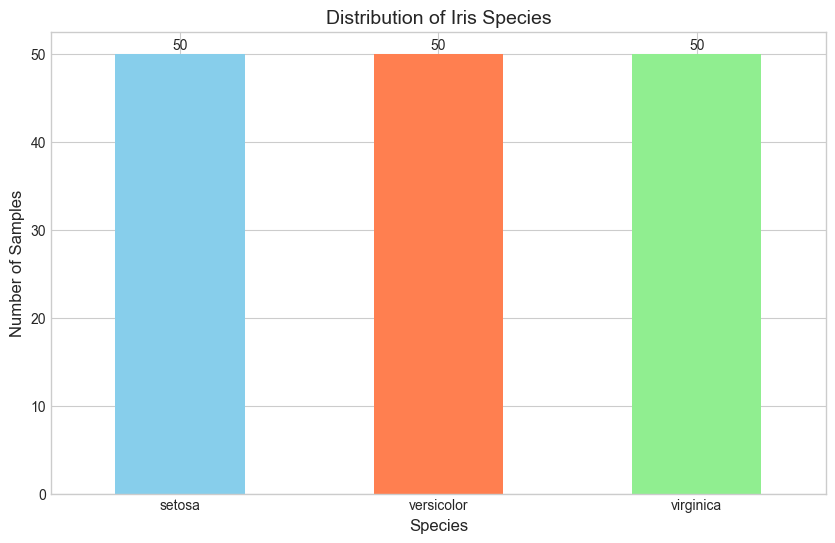

<Figure size 1400x1000 with 0 Axes>

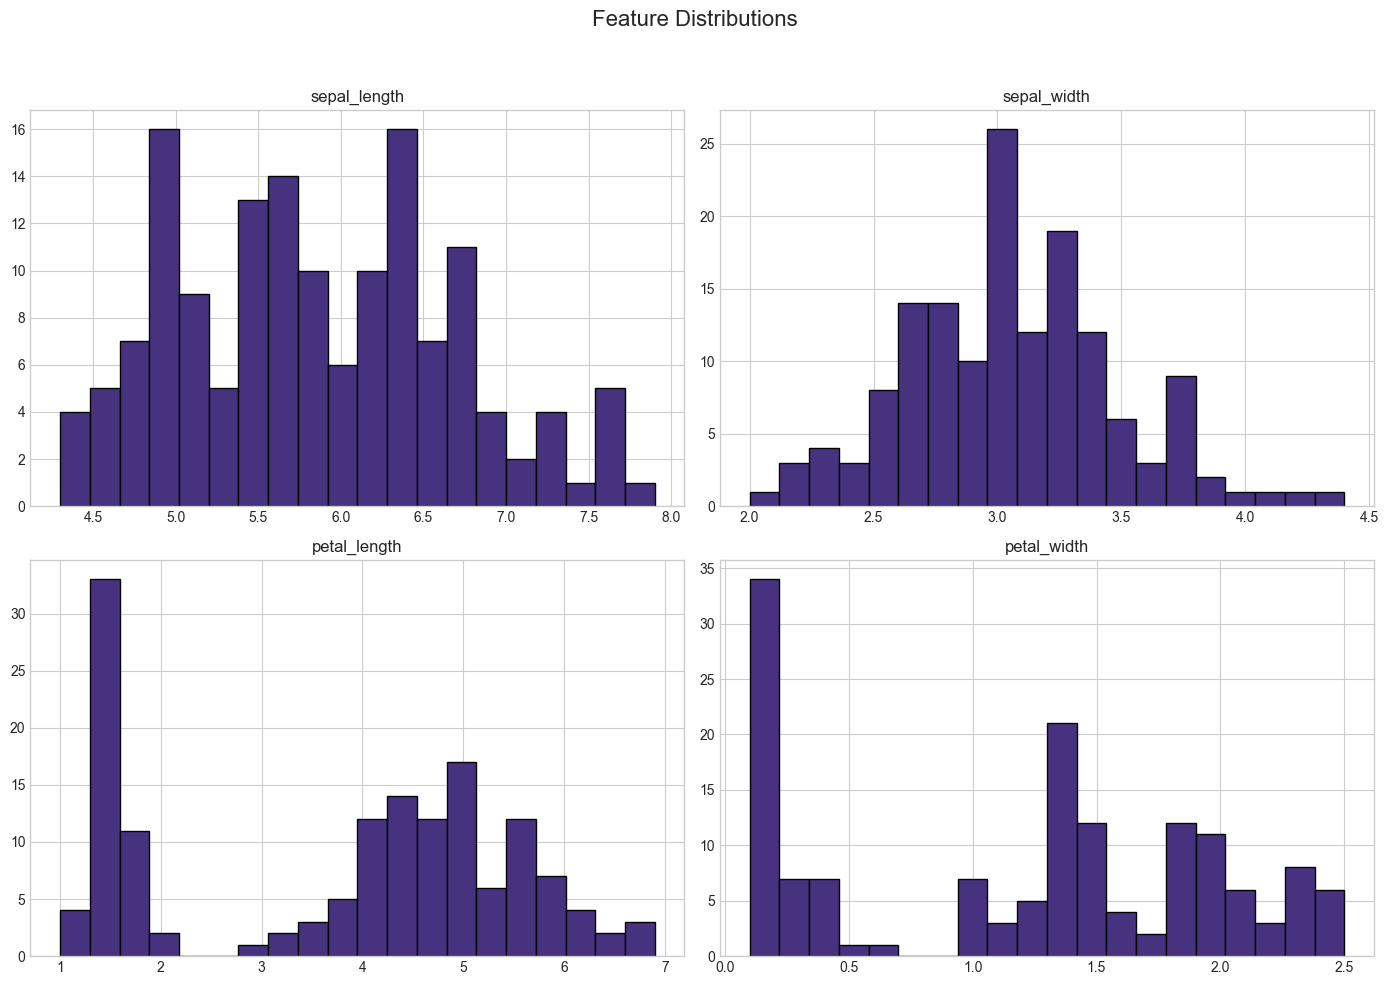

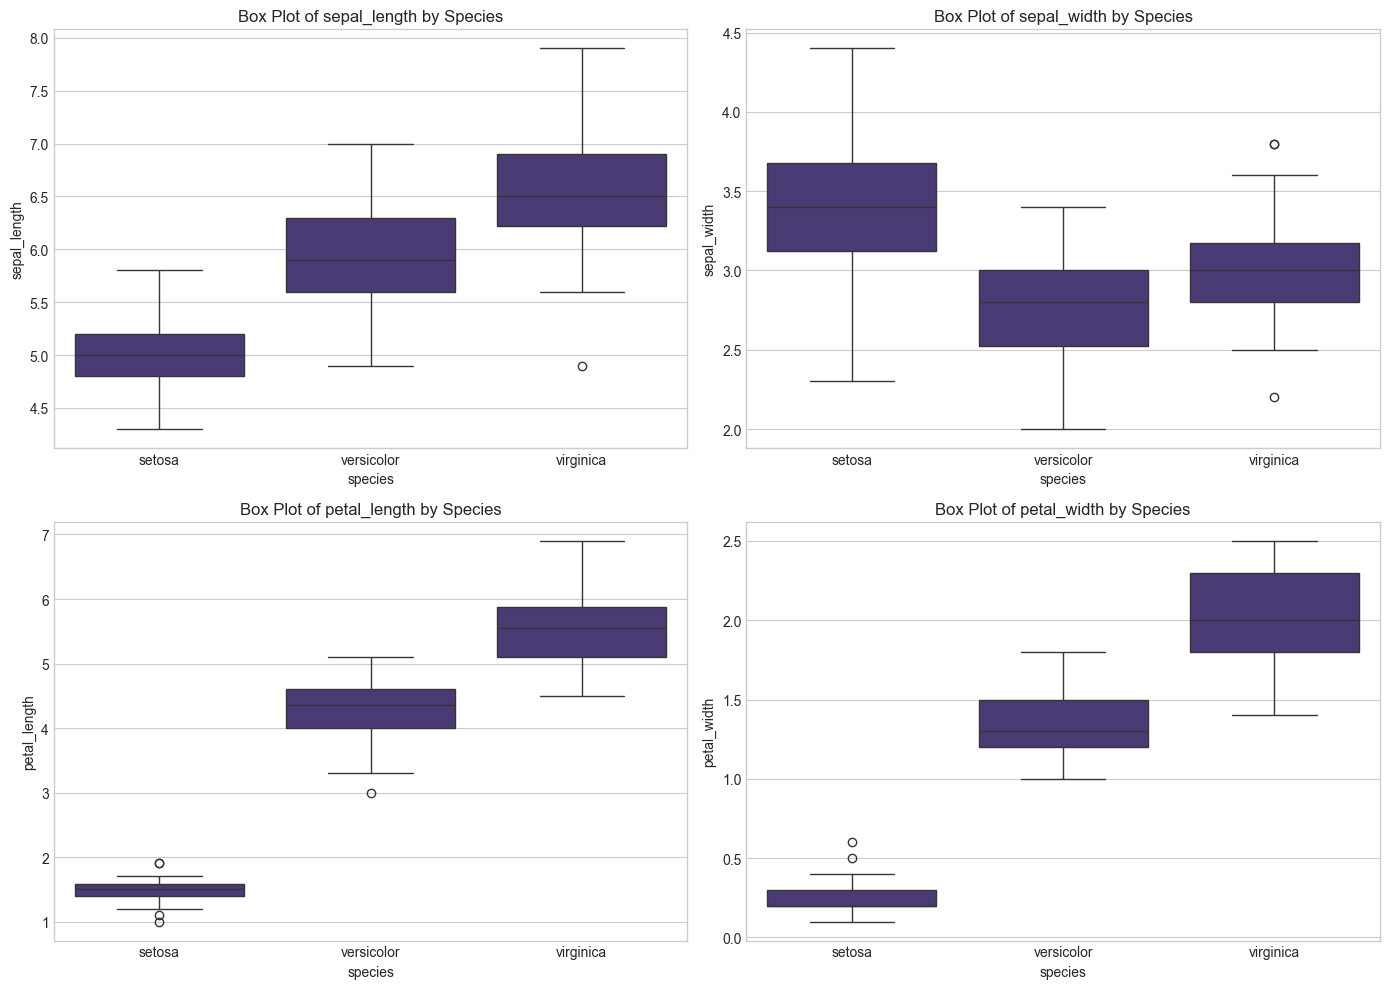

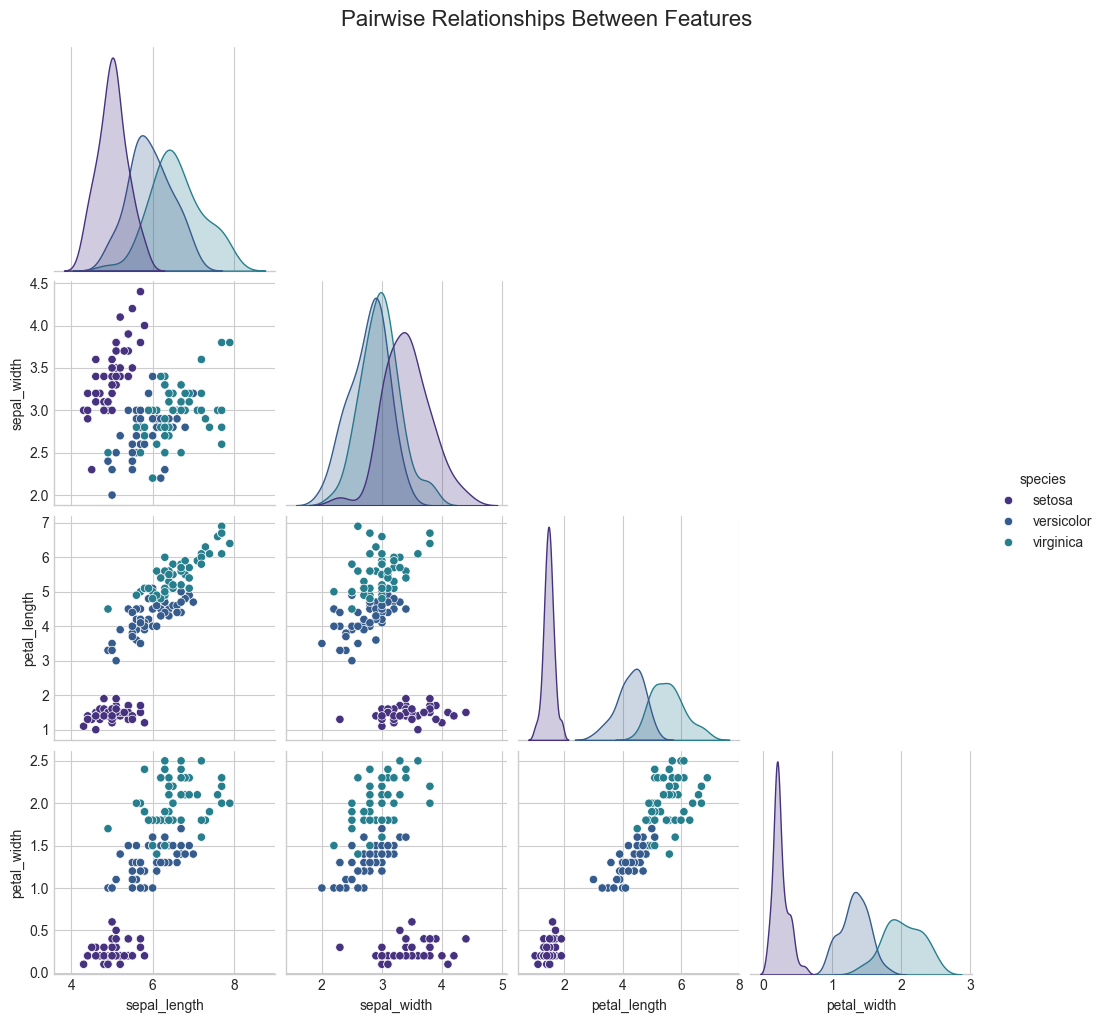

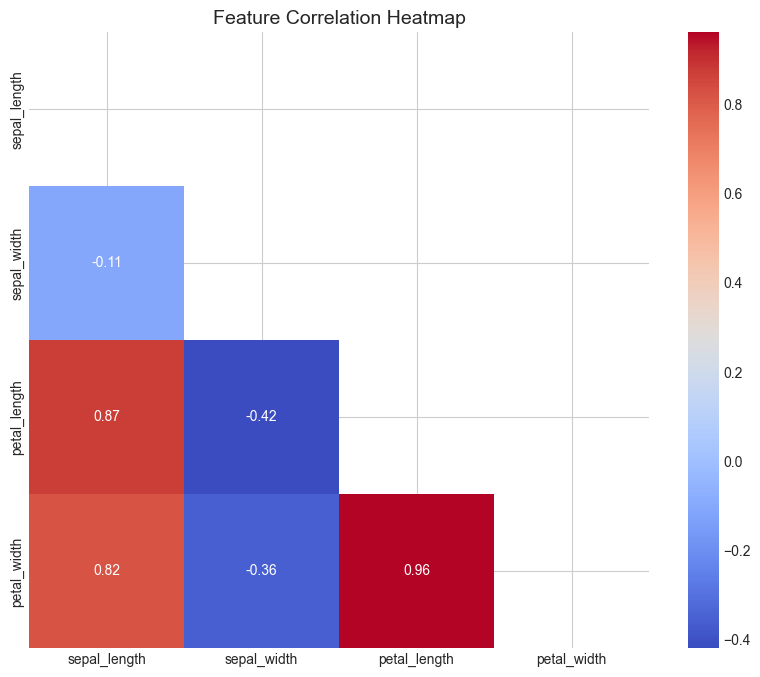


=== Data Preprocessing ===
Removing duplicate rows...
Encoding target variable...
Species mapping:
0: setosa
1: versicolor
2: virginica
Training set shape: (102, 4), Test set shape: (45, 4)

=== Feature Engineering ===
Creating ratio features...
Creating area features...
Creating normalized features...
Original feature count: 4
Engineered feature count: 16
New features created: {'sepal_area', 'norm_sepal_ratio', 'norm_sepal_area', 'norm_sepal_width', 'norm_petal_width', 'petal_area', 'norm_petal_ratio', 'norm_petal_area', 'norm_sepal_length', 'sepal_ratio', 'norm_petal_length', 'petal_ratio'}

=== Feature Selection ===
Selected 16 features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'petal_ratio', 'sepal_ratio', 'petal_area', 'sepal_area', 'norm_sepal_length', 'norm_sepal_width', 'norm_petal_length', 'norm_petal_width', 'norm_petal_ratio', 'norm_sepal_ratio', 'norm_petal_area', 'norm_sepal_area']


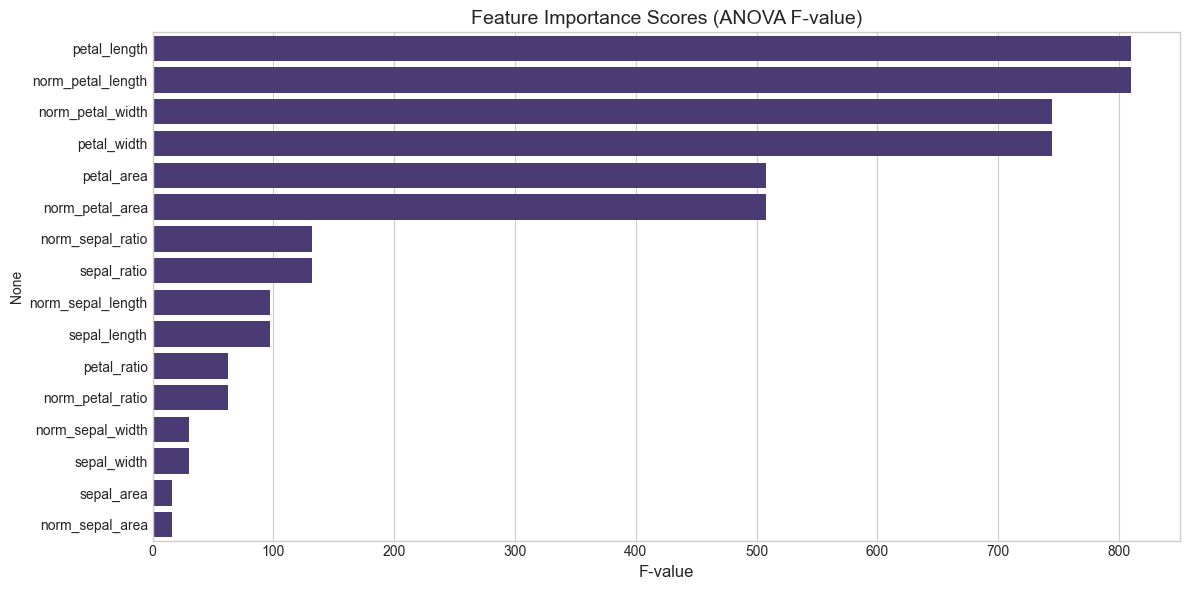


=== Training Unpruned Decision Tree ===
Tree depth: 5
Number of nodes: 11

=== Visualizing Unpruned Decision Tree ===


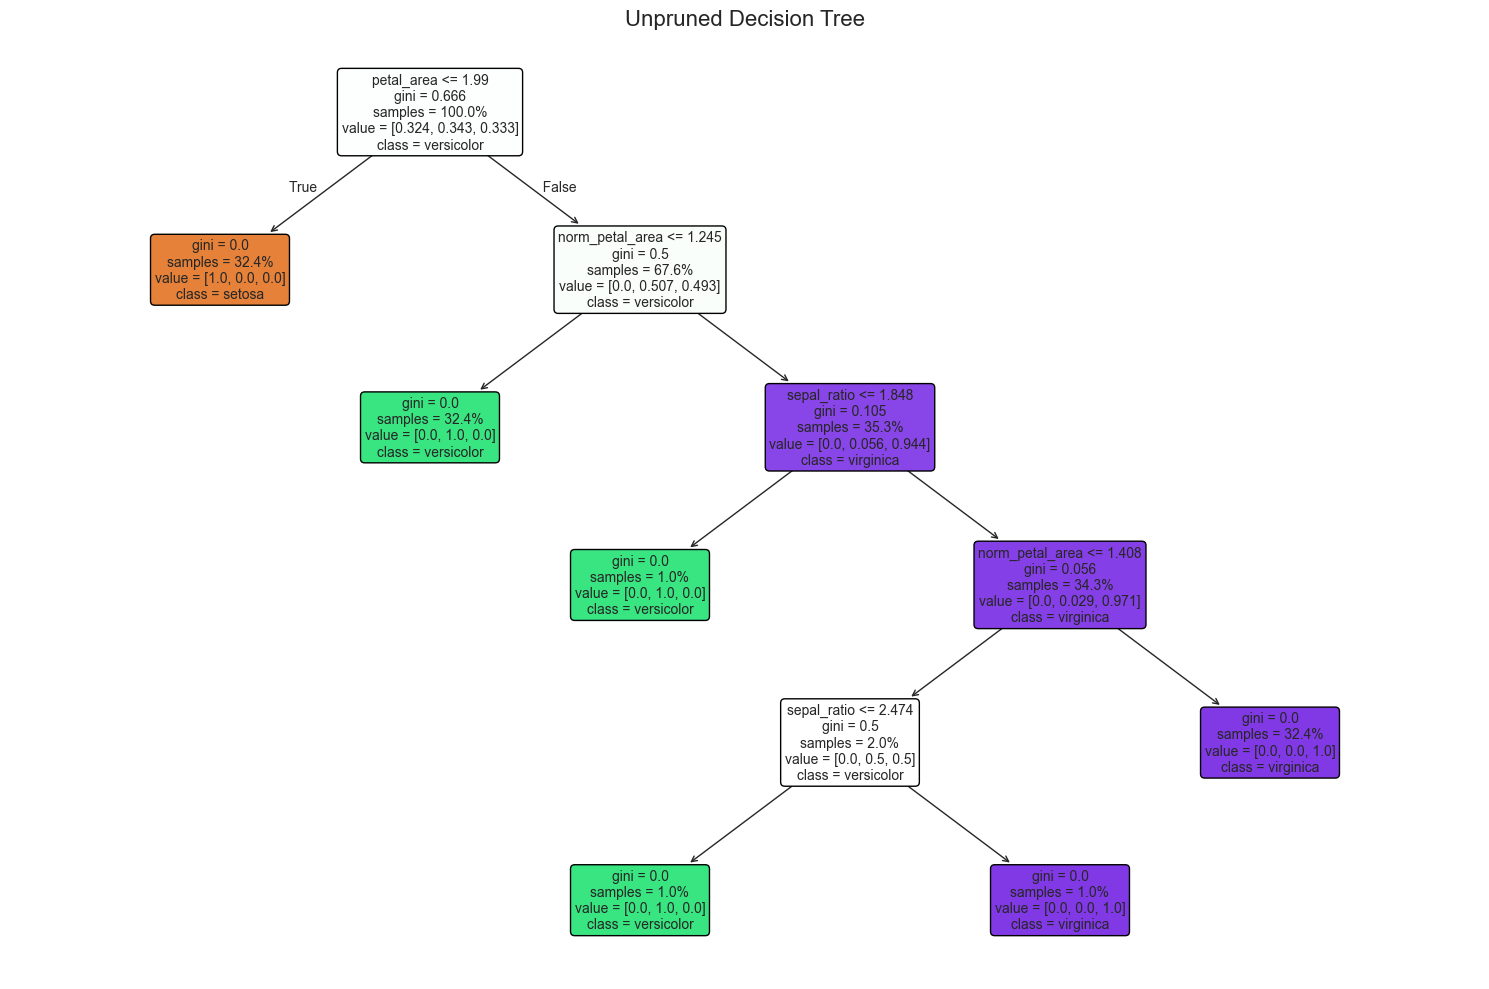


=== Finding Optimal ccp_alpha for Pruning ===


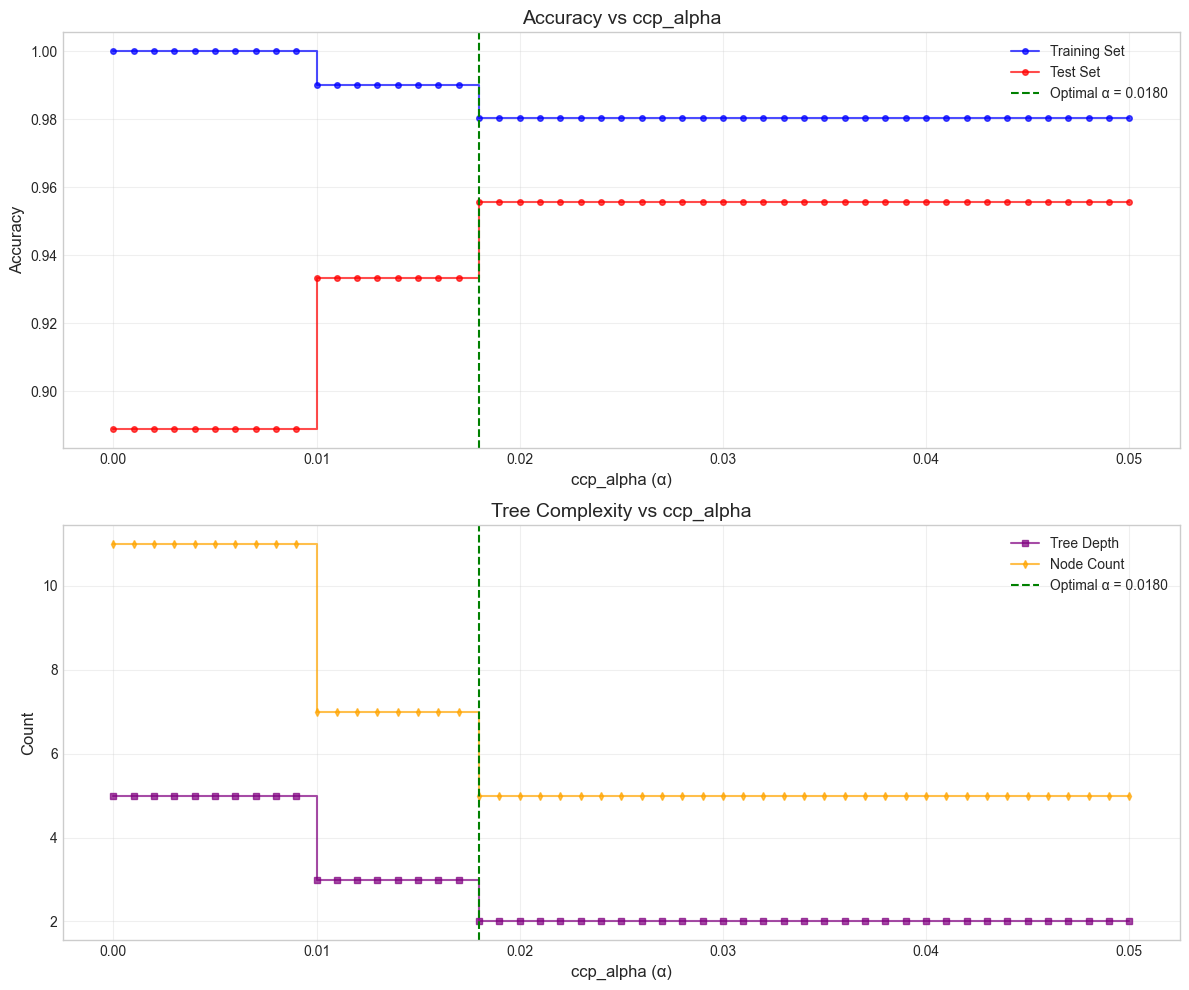

Optimal ccp_alpha: 0.0180
Corresponding test accuracy: 0.9556
Tree depth at optimal ccp_alpha: 2
Node count at optimal ccp_alpha: 5

=== Visualizing Pruned Decision Tree ===


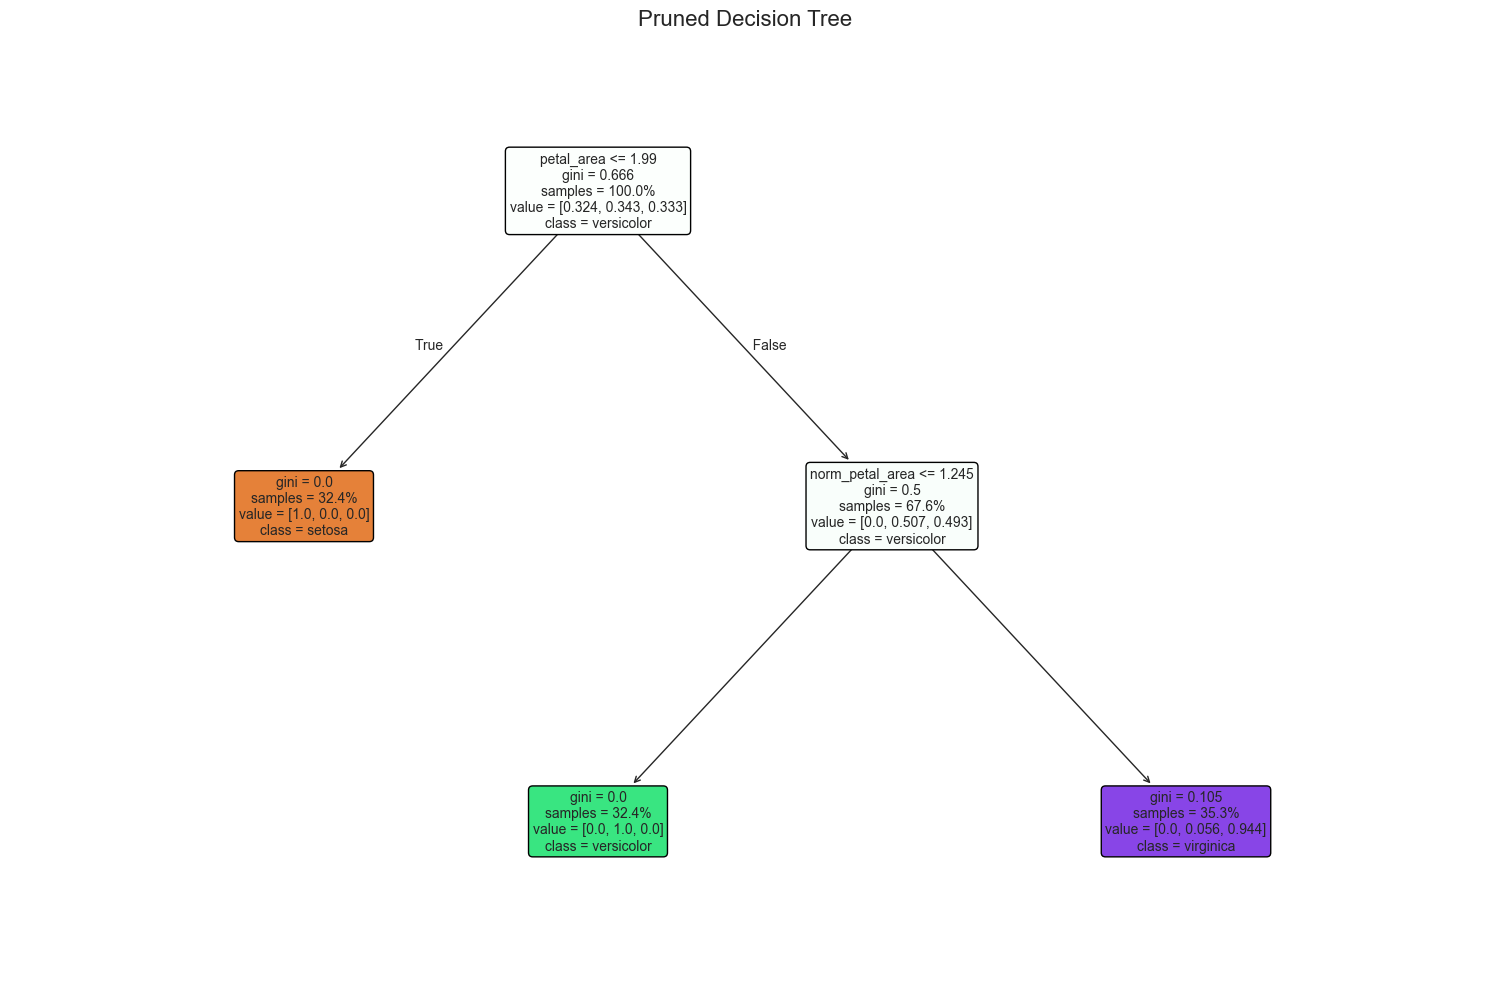


=== Cross-Validation Evaluation ===
Cross-validation accuracy scores: [0.9047619 1.        1.        1.        0.9      ]
Mean CV accuracy: 0.9610
Standard deviation of CV accuracy: 0.0478

=== Evaluating Unpruned Tree ===
Accuracy: 0.8889
Precision: 0.8981
Recall: 0.8889
F1 Score: 0.8878

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45



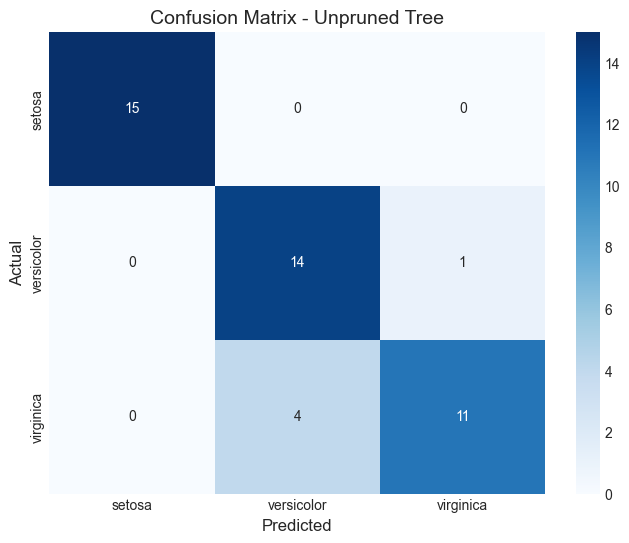


=== Evaluating Pruned Tree ===
Accuracy: 0.9556
Precision: 0.9608
Recall: 0.9556
F1 Score: 0.9554

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.87      0.93        15
   virginica       0.88      1.00      0.94        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



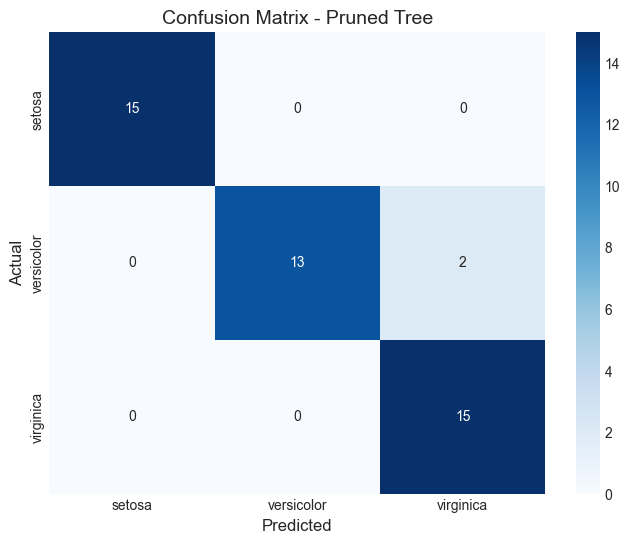


=== Model Comparison ===
          Unpruned  Pruned Improvement
Accuracy    0.8889  0.9556      0.0667
Precision   0.8981  0.9608      0.0626
Recall      0.8889  0.9556      0.0667
F1 Score    0.8878  0.9554      0.0676


<Figure size 1000x600 with 0 Axes>

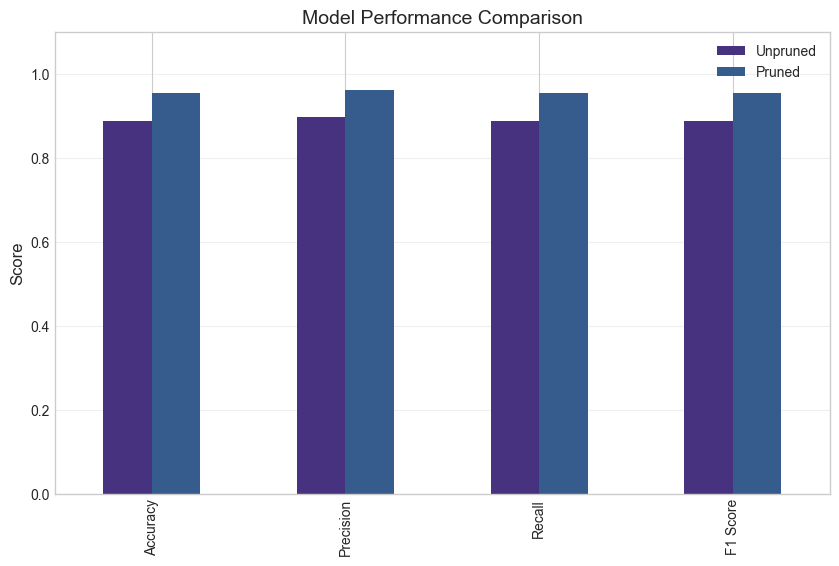


=== Feature Importance Comparison ===
Unpruned Tree Feature Importance:
  petal_area: 0.4926
  norm_petal_area: 0.4657
  sepal_ratio: 0.0417
  sepal_length: 0.0000
  petal_width: 0.0000
  petal_length: 0.0000
  petal_ratio: 0.0000
  sepal_width: 0.0000
  sepal_area: 0.0000
  norm_sepal_length: 0.0000
  norm_petal_length: 0.0000
  norm_sepal_width: 0.0000
  norm_petal_width: 0.0000
  norm_petal_ratio: 0.0000
  norm_sepal_ratio: 0.0000
  norm_sepal_area: 0.0000

Pruned Tree Feature Importance:
  petal_area: 0.5216
  norm_petal_area: 0.4784
  petal_length: 0.0000
  sepal_length: 0.0000
  petal_width: 0.0000
  petal_ratio: 0.0000
  sepal_ratio: 0.0000
  sepal_width: 0.0000
  sepal_area: 0.0000
  norm_sepal_length: 0.0000
  norm_petal_length: 0.0000
  norm_sepal_width: 0.0000
  norm_petal_width: 0.0000
  norm_petal_ratio: 0.0000
  norm_sepal_ratio: 0.0000
  norm_sepal_area: 0.0000


C:\Users\Bryant\AppData\Local\Temp\ipykernel_12736\530196474.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unpruned_importance.values, y=unpruned_importance.index, palette='viridis')
C:\Users\Bryant\AppData\Local\Temp\ipykernel_12736\530196474.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pruned_importance.values, y=pruned_importance.index, palette='viridis')


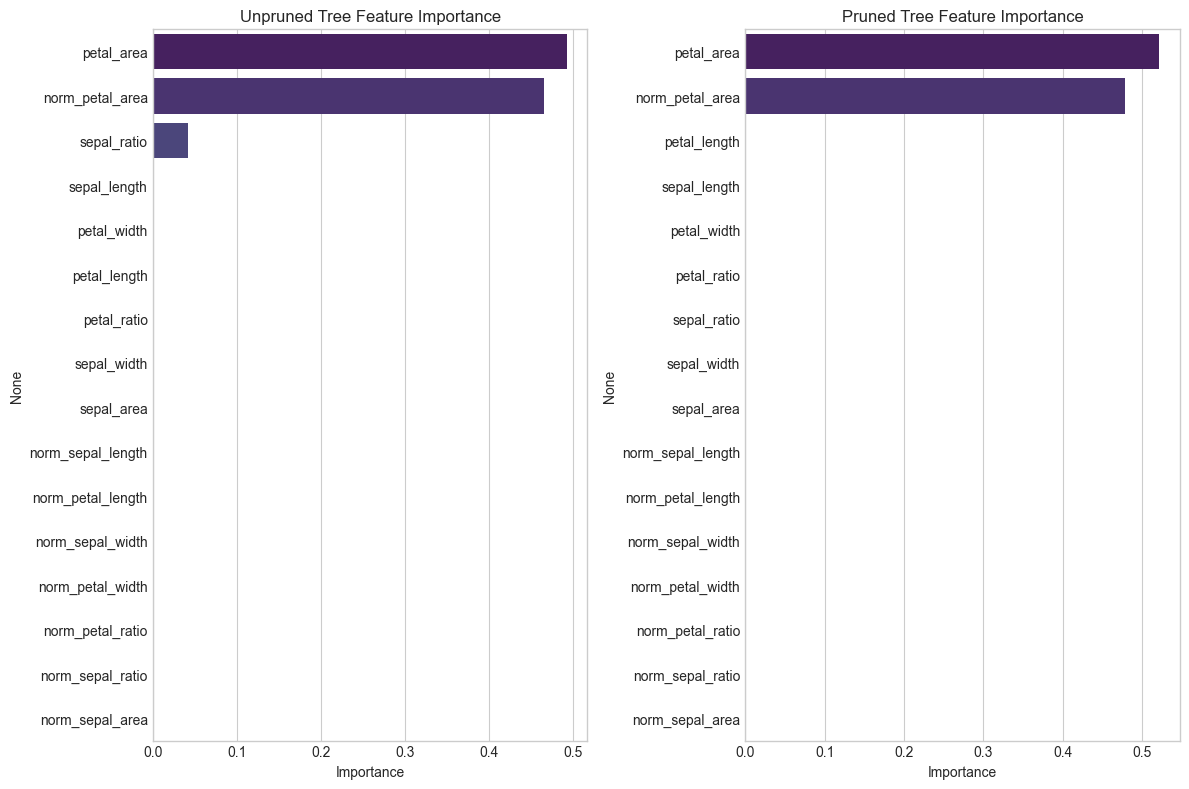


=== Summary ===
1. Dataset shape: (150, 5)
2. Number of engineered features: 16
3. Number of selected features: 16
4. Unpruned tree depth: 5
5. Pruned tree depth: 2
6. Optimal ccp_alpha: 0.0180
7. Cross-validation accuracy: 0.9610 ± 0.0478
8. Test accuracy (unpruned): 0.8889
9. Test accuracy (pruned): 0.9556

Conclusion:
Pruning was successful in improving or maintaining model performance!


In [ ]:
# Main Function

def main():
    """Main function to run the entire workflow"""
    print("=== Decision Tree Classifier for Iris Dataset ===")
    
    # 1. Load data
    df = load_data("Data set/iris.csv")
    if df is None:
        return
    
    # 2. Explore data
    explore_data(df)
    
    # 3. Preprocess data
    X_train, X_test, y_train, y_test, label_encoder = preprocess_data(df)
    if X_train is None:
        return
    
    # 4. Engineer features
    X_train_eng, X_test_eng = engineer_features(X_train, X_test)
    if X_train_eng is None:
        return
    
    # 5. Select important features
    # Use all features for this example (k=None), or specify a number like k=5
    X_train_selected, X_test_selected, selected_features = select_features(
        X_train_eng, X_test_eng, y_train, k=None
    )
    if X_train_selected is None:
        return
    
    # 6. Train unpruned decision tree
    unpruned_tree = train_unpruned_tree(X_train_selected, y_train)
    
    # 7. Visualize unpruned tree
    visualize_tree(
        unpruned_tree, 
        feature_names=selected_features,
        label_encoder=label_encoder,
        title="Unpruned Decision Tree"
    )
    
    # 8. Optimize ccp_alpha for pruning
    pruned_tree, optimal_ccp_alpha = optimize_tree_ccp_alpha(
        X_train_selected, X_test_selected, y_train, y_test
    )
    
    # 9. Visualize pruned tree
    visualize_tree(
        pruned_tree, 
        feature_names=selected_features,
        label_encoder=label_encoder,
        title="Pruned Decision Tree"
    )
    
    # 10. Perform cross-validation
    cv_scores = perform_cross_validation(X_train_selected, y_train, optimal_ccp_alpha)
    
    # 11. Evaluate models
    unpruned_metrics = evaluate_model(
        unpruned_tree, X_test_selected, y_test, 
        model_name="Unpruned Tree", label_encoder=label_encoder
    )
    
    pruned_metrics = evaluate_model(
        pruned_tree, X_test_selected, y_test, 
        model_name="Pruned Tree", label_encoder=label_encoder
    )
    
    # 12. Compare models
    compare_models(unpruned_metrics, pruned_metrics)
    
    # 13. Compare feature importance
    compare_feature_importance(unpruned_tree, pruned_tree, selected_features)
    
    # Summary
    print("\n=== Summary ===")
    print(f"1. Dataset shape: {df.shape}")
    print(f"2. Number of engineered features: {X_train_eng.shape[1]}")
    print(f"3. Number of selected features: {X_train_selected.shape[1]}")
    print(f"4. Unpruned tree depth: {unpruned_tree.get_depth()}")
    print(f"5. Pruned tree depth: {pruned_tree.get_depth()}")
    print(f"6. Optimal ccp_alpha: {optimal_ccp_alpha:.4f}")
    print(f"7. Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"8. Test accuracy (unpruned): {unpruned_metrics['accuracy']:.4f}")
    print(f"9. Test accuracy (pruned): {pruned_metrics['accuracy']:.4f}")
    
    print("\nConclusion:")
    if pruned_metrics['accuracy'] >= unpruned_metrics['accuracy']:
        print("Pruning was successful in improving or maintaining model performance!")
    else:
        diff = unpruned_metrics['accuracy'] - pruned_metrics['accuracy']
        print(f"Pruning reduced model complexity but decreased accuracy by {diff:.4f}.")
        print("However, the pruned model may generalize better to new data.")

if __name__ == "__main__":
    main()